<a href="https://colab.research.google.com/github/anutitto/dissertation/blob/main/dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=bff3d70ddf10ebdedb4c12e11e8de6aea86e71eca6de56278fdf79712e581897
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [41]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan,when,count
spark = SparkSession.builder.appName("fraud_detection_financialtransactions").getOrCreate()
df = spark.read.csv('dataset.csv', header=True, inferSchema=True)
df2 = df.select([count(when(col(c).contains('Unknown') | \
                            col(c).contains('N/A') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c
                           )).alias(c)
                    for c in df.columns])
df2.show()


+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



In [42]:
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

df_new = df.withColumn('id', row_number().over(Window.orderBy(monotonically_increasing_id())))
df_new.show()


+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+---+
|Time|       V1|       V2|       V3|       V4|       V5|       V6|       V7|       V8|       V9|      V10|      V11|      V12|      V13|      V14|      V15|      V16|      V17|      V18|      V19|      V20|      V21|      V22|      V23|      V24|      V25|      V26|      V27|      V28|Amount|Class| id|
+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+---+
|   0|-1.359807|-0.072781| 2.536347| 1.378155|-0.338321| 0.462388| 0.239599| 0.098698| 0

In [43]:
df_new=df_new.select('id','Time','V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','Amount','Class')
df_new.show()

+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+
| id|Time|       V1|       V2|       V3|       V4|       V5|       V6|       V7|       V8|       V9|      V10|      V11|      V12|      V13|      V14|      V15|      V16|      V17|      V18|      V19|      V20|      V21|      V22|      V23|      V24|      V25|      V26|      V27|Amount|Class|
+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+
|  1|   0|-1.359807|-0.072781| 2.536347| 1.378155|-0.338321| 0.462388| 0.239599| 0.098698| 0.363787| 0.090794|  -0.551

[492, 284315]
284807 31


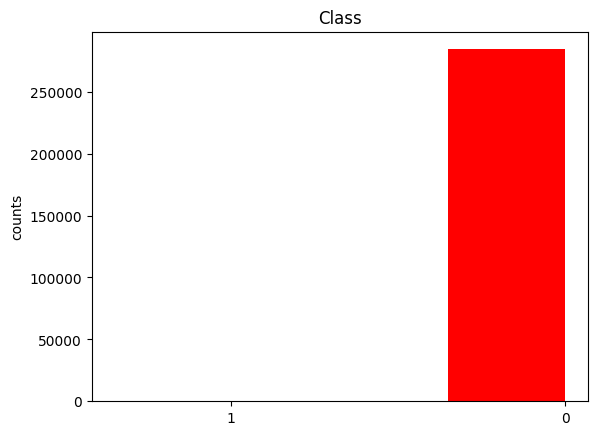

In [44]:
import numpy as np
import matplotlib.pyplot as plt

responses = df_new.groupBy('Class').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
print(counts)
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')

plt.ylabel('counts')
plt.title('Class')
plt.xticks(ind + width/2., categories)
print(df_new.count(),len(df_new.columns))

In [45]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler().setInputCols\
            (df_new.columns).setOutputCol("features")
transformed = assembler.transform(df_new)
scaler = MinMaxScaler(inputCol="features",\
         outputCol="scaledFeatures")
scalerModel =  scaler.fit(transformed.select("features"))
scaledData = scalerModel.transform(transformed)
scaledData.show()

+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+--------------------+--------------------+
| id|Time|       V1|       V2|       V3|       V4|       V5|       V6|       V7|       V8|       V9|      V10|      V11|      V12|      V13|      V14|      V15|      V16|      V17|      V18|      V19|      V20|      V21|      V22|      V23|      V24|      V25|      V26|      V27|Amount|Class|            features|      scaledFeatures|
+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+--------------------+--------------

In [67]:
def extract(row):
    return tuple(row.scaledFeatures.toArray().tolist())
final_data = scaledData.select("scaledFeatures").rdd\
               .map(extract).toDF(df_new.columns)
final_data.show()
print(final_data.count(),len(final_data.columns))
final_data=final_data.toPandas()

+--------------------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+--------------------+-----+
|                  id|                Time|                V1|                V2|                V3|                 V4|                V5|                 V6|                 V7|                V8|                 V9|               V10|                V11|               V12|                V13|               V14|                V15|                V16|               V17|               V18|          

In [68]:
import pandas as pd
final_data.to_csv("dataset_final.csv",index=False)

Counter({0: 9900, 1: 100})
Counter({0: 9900, 1: 9900})


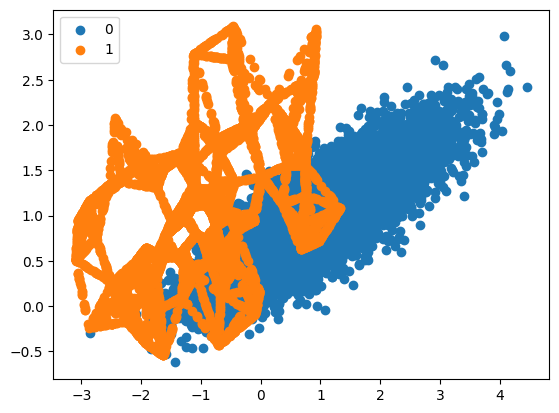

In [69]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
# define dataset
data_smote=pd.read_csv("dataset_final.csv")
X, y = data_smote(n_samples=284807, n_features=30, n_redundant=0,
 n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
 row_ix = where(y == 'Class')[0]
 pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [63]:
_import numpy as np
from imblearn.over_sampling import SMOTE

# Load data from the CSV file
data = np.loadtxt("/content/dataset_new.csv/part-00000-24d8e385-b00f-4c13-9570-c46a6f18be8e-c000.csv", delimiter=",", dtype=np.float32)
features = data[:, :-1]  # All columns except the last one are features
labels = data[:, -1]

# Round the labels to the nearest integer
labels = np.round(labels).astype(int)

# Find the indices of the minority class (class label 1) and majority class (class label 0)
label_min = np.where(labels == 1)[0]
label_maj = np.where(labels == 0)[0]

# Create a balanced subset with a few instances from both classes
num_samples_per_class = 140000
subset_indices = np.concatenate((label_min[:num_samples_per_class], label_maj[:num_samples_per_class]))

# Apply SMOTE to the smaller balanced subset
smote = SMOTE(sampling_strategy='auto', k_neighbors=5)
smote_dataInput_min, _ = smote.fit_resample(features[subset_indices], labels[subset_indices])

# Combine the synthetic minority instances with the original majority instances.
oversampled_X = np.vstack((smote_dataInput_min, features[labels == 0]))

# Save the oversampled data.
balanced_data = np.column_stack((oversampled_X, np.hstack((np.repeat(1, len(smote_dataInput_min)), np.repeat(0, len(features[labels == 0]))))))
np.savetxt("balanced_data_final.csv", balanced_data, delimiter=",")


TypeError: ignored

In [59]:
smote_data = spark.read.csv('/content/balanced_data_final.csv', header=True, inferSchema=True)
column_headings = ['id','Time','V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','Amount','Class']

# Add column headings to the DataFrame
smote_with_headings = smote_data.toDF(*column_headings)

# Show the DataFrame with column headings
smote_with_headings.show()
print(smote_data.count(),len(smote_data.columns))


+--------------------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+--------------------+-----+
|                  id|                Time|                V1|                V2|                V3|                 V4|                V5|                 V6|                 V7|                V8|                 V9|                V10|                V11|                V12|                V13|                V14|                V15|                V16|               V17|                V18| 

[279999, 271729]


([<matplotlib.axis.XTick at 0x7bc28ecd8f40>,
 [Text(0.175, 0, '1.0'), Text(1.175, 0, '0.0')])

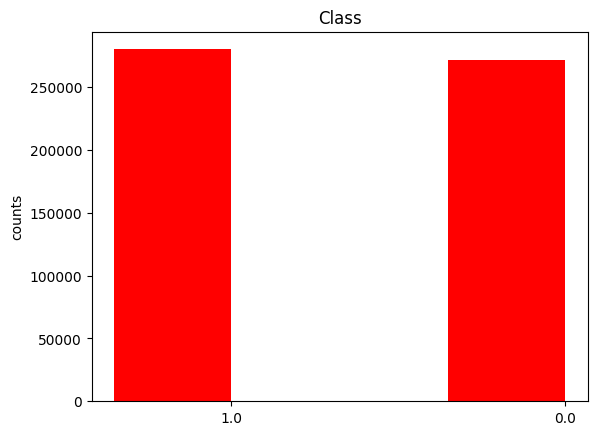

In [60]:

responses = smote_with_headings.groupBy('Class').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
print(counts)

ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')

plt.ylabel('counts')
plt.title('Class')
plt.xticks(ind + width/2., categories)
